MACHINE LEARNING FOR DIABETELOVERS\
guarda libreria LangChain\
HuggingFace --> modelli di machine learning per qualsiasi cosa

In [2]:
#LIBRERIE

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn', Voglio rimuovere un warning dato in fase di .loc durante lo smoting
pd.set_option('display.max_rows',50)
from pandas.plotting._matplotlib import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit

import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import random as tf_random

from sklearn.neighbors import KDTree

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


In [3]:
#PATHs inseriti qui per eventuali cambi

data_path = "C:/Users/Simone Feliziani/Documents/Progetti_autonomi/Python Scripts/Diabetes_ML/Diabetes_prediction/data/Dataset_02/diabetes_prediction_dataset.csv"
output_file_path = "C:/Users/Simone Feliziani/Documents/Progetti_autonomi/Python Scripts/Diabetes_ML/Diabetes_prediction/data/Temp_shuffled_data/"

In [4]:
#Parametri

df_train_fraction = 0.8
df_balance_percent = 0.525
df_smote_increment = 3
cut = 'y'

In [5]:
#TensorFlow with parallel GPU processing

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Num GPUs Available: ", len(gpus))
else:
    print("No GPUs Available, using CPU instead.")

No GPUs Available, using CPU instead.


In [6]:
def df_encoding(df,drop_NoInfo):
    # OneHotEncoder - gender
    encoder = OneHotEncoder(sparse_output=False)
    gender_encoded = encoder.fit_transform(df[['gender']])
    encoded_df = pd.DataFrame(gender_encoded, columns=encoder.get_feature_names_out(['gender']))
    df_encoded = pd.concat([df, encoded_df], axis=1)
    df_encoded.drop(columns=['gender'], inplace=True)
    #df_encoded.drop(columns=['gender_Other'], inplace=True)

    # OrdinalEncoder - Smoking_history
    #encoder = OrdinalEncoder(categories=[['No Info', 'never', 'former', 'current']])
    #encoded_column = encoder.fit_transform(df[['smoking_history']])
    #df['smoking_history'] = encoded_column
    
    smoke_encoded = encoder.fit_transform(df_encoded[['smoking_history']])
    encoded_df = pd.DataFrame(smoke_encoded, columns=encoder.get_feature_names_out(['smoking_history']))
    df_encoded = pd.concat([df_encoded,encoded_df], axis=1)
    df_encoded.drop(columns=['smoking_history'], inplace=True)
    if(drop_NoInfo == 'y'):
        df_encoded.drop(columns=['smoking_history_No Info'], inplace=True)
    elif(drop_NoInfo != 'n'):
        print('Error: set "drop_NoInfo" value to [y/n]') 

    column_to_move = df_encoded.pop('diabetes')
    df_encoded['diabetes'] = column_to_move
    
    return df_encoded

#funzione di sklearn --> train_test_split fa la stessa cosa, mischia e separa ad ogni run
def shuffle_split(df,seed):

    df_size = np.shape(df)[1]
    df_test_fraction  = 1-df_train_fraction
    df_train_amount = int(df_train_fraction*np.shape(df)[0])
    df_test_amount  = int(df_test_fraction*np.shape(df)[0])

    db_shuffled = df.sample(frac=1).reset_index(drop=True)
    features = db_shuffled.iloc[:, :df_size-1]
    labels = db_shuffled.iloc[:, -1]

    x_train, y_train = features[0:df_train_amount], labels[0:df_train_amount]
    x_test, y_test = features[df_test_amount:np.shape(df)[0]-1], labels[df_test_amount:np.shape(df)[0]-1]

    # salviamo il DataFrame mescolato in un nuovo file .csv
    db_shuffled.to_csv(output_file_path + f'shuffled_data_{seed}.csv', index=False)

    return x_train ,y_train,x_test,y_test

def df_cut(df):
    label_False = df[ df['diabetes'] == 0 ].index
    label_True = df[df['diabetes'] == 1 ].index
    df_False_drop = np.shape(df)[0]-np.shape(label_True)[0]*(2*df_balance_percent+1)
    rows_to_remove = np.random.choice(label_False, int(df_False_drop), replace=False)
    df = df.drop(rows_to_remove)

    return df

def choose_gender(v):
    if v[6]>v[7] and v[6]>v[8]:
        v[6]=1
        v[7]=0
        v[8]=0
    elif v[7]>v[6] and v[7]>v[8]:
        v[6]=0
        v[7]=1
        v[8]=0
    elif v[8]>v[6] and v[8]>v[7]:
        v[6]=0
        v[7]=0
        v[8]=1
    elif v[6]==v[7]:
        v[8]=0
        choice = random.randint(1,2)
        if choice == 1:
            v[6]=1
            v[7]=0
        else:
            v[6]=0
            v[7]=1
    else:
        v[6]=0
        v[7]=0
        v[8]=1
        
    return v

def choose_smoking_habit(v):
    smoke_habits = np.array([v[9],v[10],v[11],v[12],v[13]])
    smoke_index = [9,10,11,12,13]
    if np.array_equal(smoke_habits,np.array([0,0,0,0,0])):
        max_index = np.argmax(smoke_habits)
        v[max_index]=1
        del smoke_index[max_index]
        for i in smoke_index:
            v[i]=0
    else:
        for i in smoke_index:
            v[i]=0
    return v

def set_integers(v):
    v[14]=1
    v[0]=round(v[0])
    if v[1]>1:
        v[1]=v[1]-1
    v[1]=round(v[1])
    if v[2]>1:
        v[2]=v[2]-1
    v[2]=round(v[2])
    v[5]=round(v[5])
    return v

def smote(df):
    extra_row_index=0
    label_True = df[df['diabetes'] == 1 ]
    df_smoted = label_True
    kdtree = KDTree(label_True, leaf_size=30)
    for index in range(np.shape(label_True)[0]):
        distances, indices = kdtree.query(label_True.iloc[[index]].values,k=int(df_smote_increment))
        for i in indices[0]:
            pick_in_the_middle = random.random()
            #new_datapoint = (label_True.iloc[indices[0][0]].values - label_True.iloc[[index]].values)*pick_in_the_middle + label_True.iloc[indices[0][0]].values
            new_datapoint = (label_True.iloc[i].values - label_True.iloc[[index]].values)*pick_in_the_middle + label_True.iloc[i].values
            new_datapoint[0] = set_integers(new_datapoint[0])
            new_datapoint[0] = choose_gender(new_datapoint[0])
            new_datapoint[0] = choose_smoking_habit(new_datapoint[0])
            df_smoted.loc[np.shape(df)[0]+extra_row_index] = new_datapoint[0]
            extra_row_index = extra_row_index + 1
    #print(np.shape(df_smoted))
    #print(df_smoted)
    df_smoted = pd.concat([df,df_smoted])
    return df_smoted
    
        


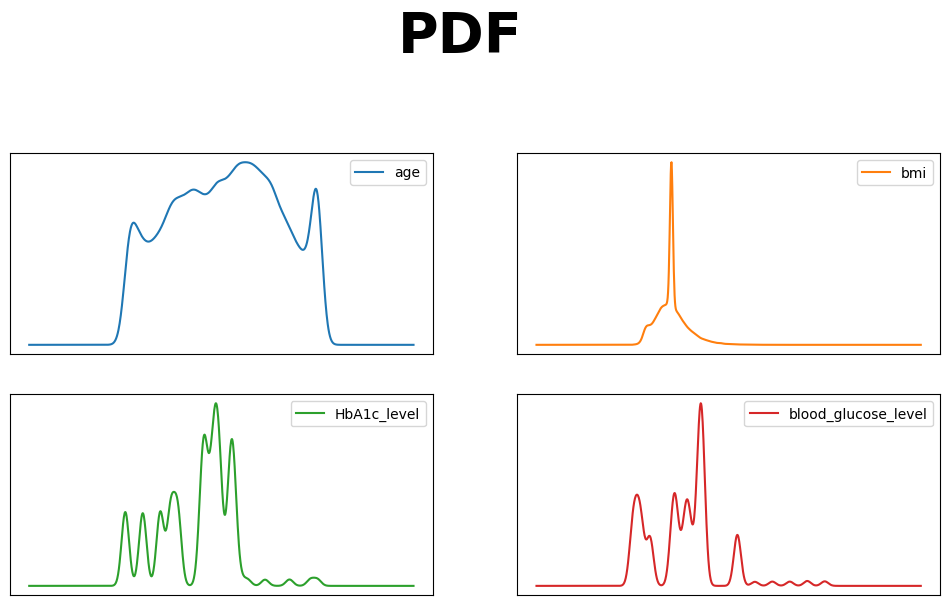

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [18]:
#DATA MANAGEMENT

db_df = pd.read_csv(data_path)

#STAMPA PDF
selected_columns = db_df.iloc[:, [1, 5, 6, 7]]
#db_df.plot(kind="density",subplots=True,layout=(5,2),sharex=False,fontsize=16,figsize=(15,15))
axes = selected_columns.plot(kind="density",subplots=True,layout=(4,2),sharex=False,fontsize=16,figsize=(12,12))
plt.suptitle("PDF",y=1.00,fontweight='bold',fontsize=40)
for ax in axes.flatten():
    ax.set_xticks([])  # Rimuovi i numeri dall'asse x
    ax.set_yticks([])  # Rimuovi i numeri dall'asse y
    ax.set_xlabel('')  # Rimuovi l'etichetta dell'asse x
    ax.set_ylabel('')  # Rimuovi l'etichetta dell'asse y
plt.show()

#STAMPA CORRELATION SCATTERPLOT
'''
Axes = scatter_matrix(db_df, figsize=(15,15))
plt.suptitle("Scatter Matrix", y=1.00, fontweight='bold',fontsize=30)
plt.rcParams['axes.labelsize'] = 15
[plt.setp(item.yaxis.get_majorticklabels(),'size',15) for item in Axes.ravel()]
[plt.setp(item.xaxis.get_majorticklabels(),'size',15) for item in Axes.ravel()]
plt.show()
'''
#STAMPA CORRELATION HEATMAP
'''
#Necessita di encoding
plt.figure(figsize = (12,12))
plt.style.use('default')
sns.heatmap(db_df.corr(),annot=True)
'''




#print(db_df.describe())
#db_df = df_encoding(db_df,'y')
db_df




In [21]:
#TESTS

#db_df = smote(db_df)
#np.shape(db_df)
#db_df = df_cut(db_df)
#print(db_df.iloc[0][6],db_df.iloc[0][7],db_df.iloc[0][8])
#db_df.iloc[0]
#db_df

#db_df.at[0,'gender_Female'] = 0.32
#db_df.at[0,'gender_Male'] = 0.67

#db_df.iloc[0]=choose_gender(db_df.iloc[0].values)
#db_df
#label_True = db_df[db_df['diabetes'] == 1 ]
#kdtree = KDTree(label_True, leaf_size=30)
#for index,row in db_df.iterrows():
#    distances, indices = kdtree.query(db_df.iloc[[index]].values,k=2)
#    print(db_df.iloc[indices[0][1]].values)
    #print(indices)
#np.shape(label_True)[0]
#db_df['hypertension'].unique()

87125 15


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7952 - loss: 0.4329 - val_accuracy: 0.8871 - val_loss: 0.2523
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8881 - loss: 0.2507 - val_accuracy: 0.8918 - val_loss: 0.2414
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8928 - loss: 0.2380 - val_accuracy: 0.8978 - val_loss: 0.2267
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8999 - loss: 0.2216 - val_accuracy: 0.9054 - val_loss: 0.2112
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9075 - loss: 0.2060 - val_accuracy: 0.9080 - val_loss: 0.2008
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9109 - loss: 0.1959 - val_accuracy: 0.9110 - val_loss: 0.1953
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9137 - loss: 0.1904 - val_accuracy: 0.9117 - val_loss: 0.1924
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9146 - loss: 0.1870 - val_accu

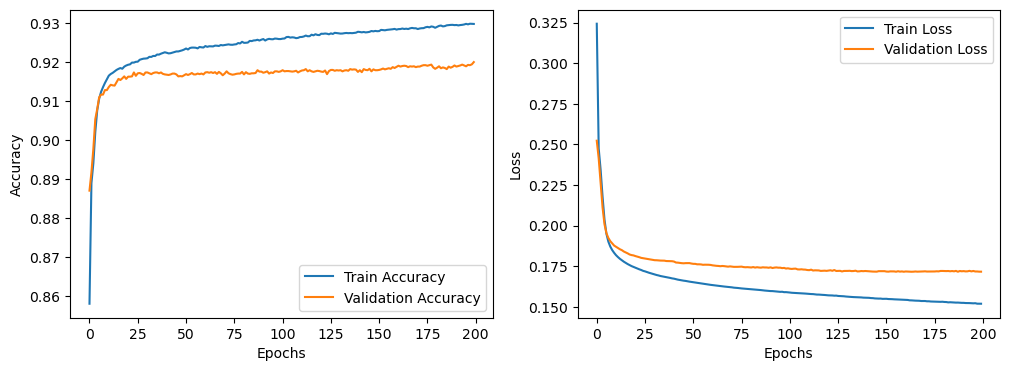

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9303 - loss: 0.1510
87125 15
Epoch 1/200


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7949 - loss: 0.4407 - val_accuracy: 0.8900 - val_loss: 0.2463
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8861 - loss: 0.2568 - val_accuracy: 0.8925 - val_loss: 0.2381
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8901 - loss: 0.2481 - val_accuracy: 0.8975 - val_loss: 0.2285
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8937 - loss: 0.2368 - val_accuracy: 0.9018 - val_loss: 0.2143
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8986 - loss: 0.2213 - val_accuracy: 0.9097 - val_loss: 0.1991
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9048 - loss: 0.2066 - val_accuracy: 0.9138 - val_loss: 0.1894
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9082 - loss: 0.1974 - val_accuracy: 0.9161 - val_loss: 0.1840
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9107 - loss: 0.1921 - val_accuracy: 0.9157

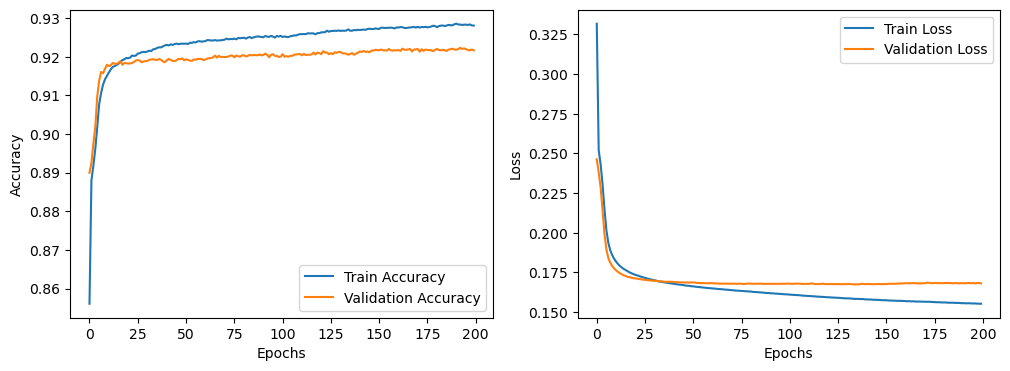

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9276 - loss: 0.1545
87125 15


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8221 - loss: 0.4187 - val_accuracy: 0.8874 - val_loss: 0.2509
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8865 - loss: 0.2526 - val_accuracy: 0.8917 - val_loss: 0.2422
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8904 - loss: 0.2429 - val_accuracy: 0.8954 - val_loss: 0.2313
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8960 - loss: 0.2303 - val_accuracy: 0.9016 - val_loss: 0.2172
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9025 - loss: 0.2153 - val_accuracy: 0.9067 - val_loss: 0.2047
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9072 - loss: 0.2025 - val_accuracy: 0.9085 - val_loss: 0.1969
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9097 - loss: 0.1944 - val_accuracy: 0.9100 - val_loss: 0.1926
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9112 - loss: 0.1898 - val_accu

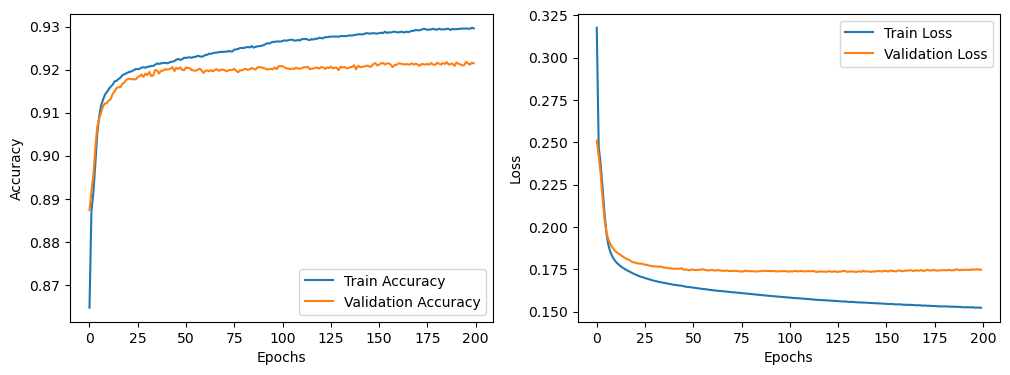

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9264 - loss: 0.1575
87125 15
Epoch 1/200


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8141 - loss: 0.4260 - val_accuracy: 0.8846 - val_loss: 0.2532
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8889 - loss: 0.2471 - val_accuracy: 0.8894 - val_loss: 0.2440
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8925 - loss: 0.2371 - val_accuracy: 0.8947 - val_loss: 0.2317
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8992 - loss: 0.2237 - val_accuracy: 0.9008 - val_loss: 0.2165
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9056 - loss: 0.2085 - val_accuracy: 0.9065 - val_loss: 0.2028
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9118 - loss: 0.1954 - val_accuracy: 0.9118 - val_loss: 0.1942
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9147 - loss: 0.1877 - val_accuracy: 0.9120 - val_loss: 0.1898
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9158 - loss: 0.1836 - val_accuracy: 0.9132

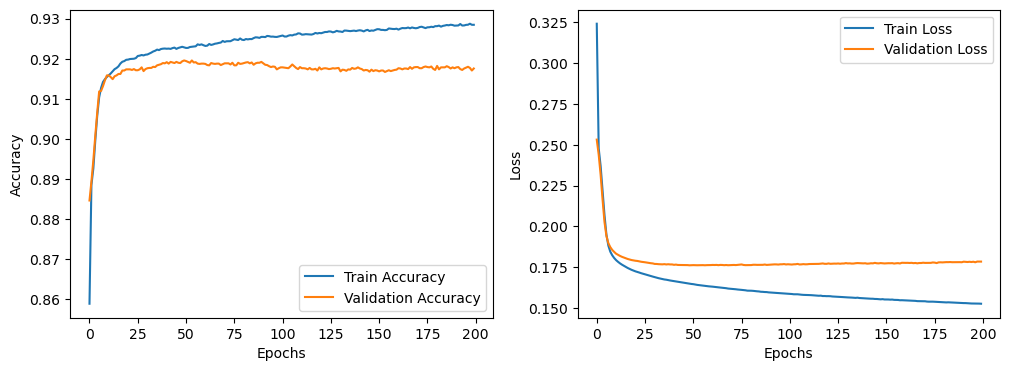

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9269 - loss: 0.1558
87125 15
Epoch 1/200


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8213 - loss: 0.4217 - val_accuracy: 0.8873 - val_loss: 0.2538
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8869 - loss: 0.2507 - val_accuracy: 0.8916 - val_loss: 0.2434
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8908 - loss: 0.2397 - val_accuracy: 0.8969 - val_loss: 0.2289
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8981 - loss: 0.2246 - val_accuracy: 0.9035 - val_loss: 0.2136
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9045 - loss: 0.2094 - val_accuracy: 0.9078 - val_loss: 0.2020
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9080 - loss: 0.1990 - val_accuracy: 0.9094 - val_loss: 0.1956
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9104 - loss: 0.1929 - val_accuracy: 0.9119 - val_loss: 0.1918
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9126 - loss: 0.1888 - val_accuracy: 0.9127

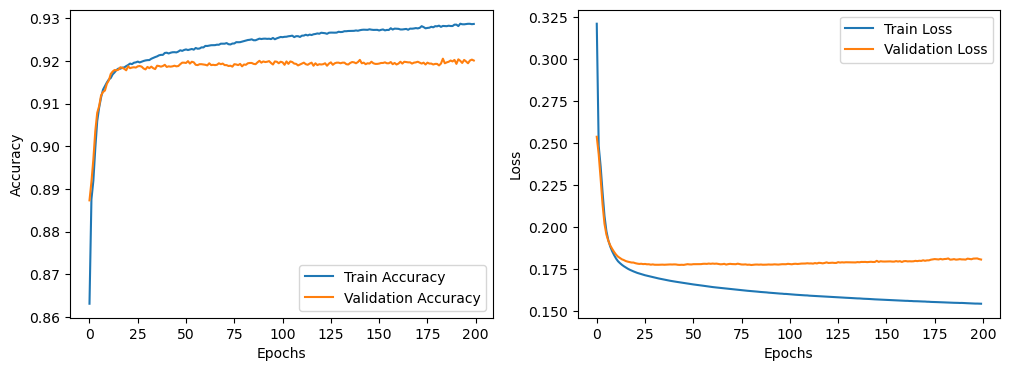

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9285 - loss: 0.1565
87125 15
Epoch 1/200


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8164 - loss: 0.4175 - val_accuracy: 0.8843 - val_loss: 0.2563
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8887 - loss: 0.2462 - val_accuracy: 0.8897 - val_loss: 0.2451
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - loss: 0.2361 - val_accuracy: 0.8958 - val_loss: 0.2327
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8971 - loss: 0.2230 - val_accuracy: 0.9034 - val_loss: 0.2161
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9049 - loss: 0.2072 - val_accuracy: 0.9076 - val_loss: 0.2031
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9093 - loss: 0.1961 - val_accuracy: 0.9096 - val_loss: 0.1964
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9111 - loss: 0.1903 - val_accuracy: 0.9104 - val_loss: 0.1929
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9120 - loss: 0.1869 - val_accuracy: 0.9115

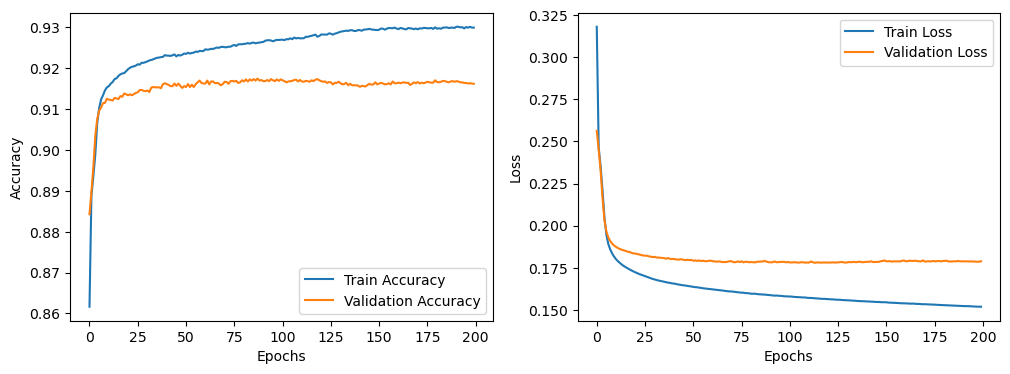

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9291 - loss: 0.1540
87125 15
Epoch 1/200


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7901 - loss: 0.4455 - val_accuracy: 0.8879 - val_loss: 0.2491
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8852 - loss: 0.2564 - val_accuracy: 0.8932 - val_loss: 0.2389
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8887 - loss: 0.2461 - val_accuracy: 0.8981 - val_loss: 0.2261
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8938 - loss: 0.2321 - val_accuracy: 0.9040 - val_loss: 0.2116
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9004 - loss: 0.2171 - val_accuracy: 0.9080 - val_loss: 0.1996
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9048 - loss: 0.2054 - val_accuracy: 0.9121 - val_loss: 0.1921
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9079 - loss: 0.1979 - val_accuracy: 0.9138 - val_loss: 0.1878
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9094 - loss: 0.1934 - val_accuracy: 0.9146

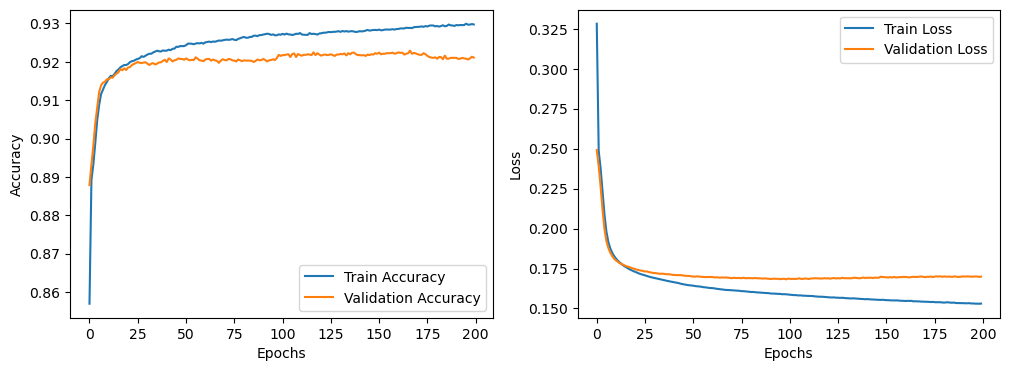

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9272 - loss: 0.1559
87125 15
Epoch 1/200


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8566 - loss: 0.3997 - val_accuracy: 0.8870 - val_loss: 0.2526
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8880 - loss: 0.2479 - val_accuracy: 0.8910 - val_loss: 0.2428
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8932 - loss: 0.2368 - val_accuracy: 0.8961 - val_loss: 0.2305
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8990 - loss: 0.2234 - val_accuracy: 0.9014 - val_loss: 0.2162
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9042 - loss: 0.2094 - val_accuracy: 0.9069 - val_loss: 0.2034
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9087 - loss: 0.1978 - val_accuracy: 0.9093 - val_loss: 0.1952
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9120 - loss: 0.1905 - val_accuracy: 0.9118 - val_loss: 0.1902
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9142 - loss: 0.1859 - val_accuracy: 0.9123

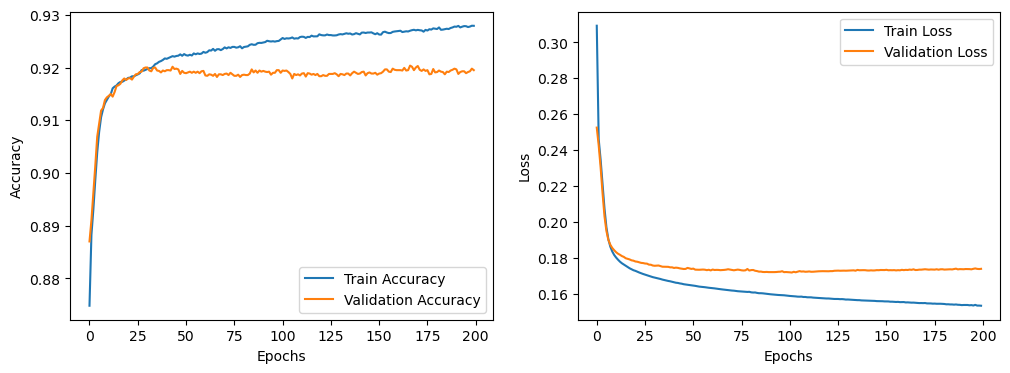

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9281 - loss: 0.1591
87125 15


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7967 - loss: 0.4098 - val_accuracy: 0.8848 - val_loss: 0.2549
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8888 - loss: 0.2468 - val_accuracy: 0.8892 - val_loss: 0.2435
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8940 - loss: 0.2355 - val_accuracy: 0.8956 - val_loss: 0.2309
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8983 - loss: 0.2227 - val_accuracy: 0.9030 - val_loss: 0.2149
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9047 - loss: 0.2077 - val_accuracy: 0.9076 - val_loss: 0.2002
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9090 - loss: 0.1956 - val_accuracy: 0.9114 - val_loss: 0.1911
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9115 - loss: 0.1884 - val_accuracy: 0.9140 - val_loss: 0.1863
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9129 - loss: 0.1843 - val_accu

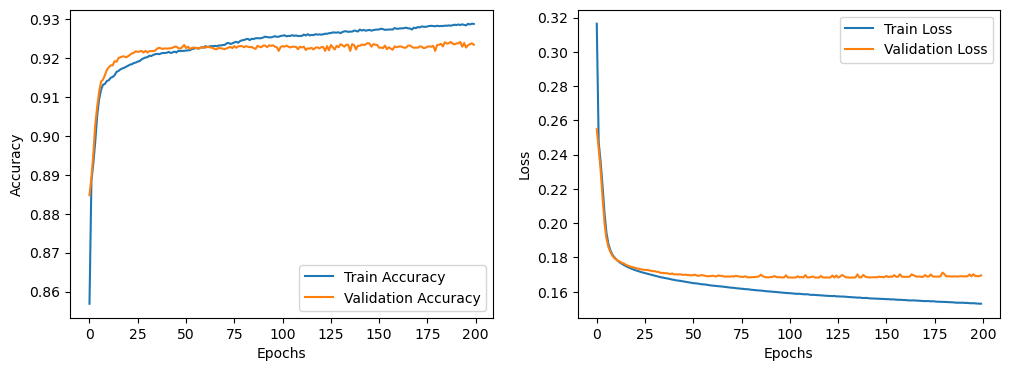

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9281 - loss: 0.1535
87125 15


C:\Users\Simone Feliziani\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7625 - loss: 0.4588 - val_accuracy: 0.8829 - val_loss: 0.2557
Epoch 2/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8896 - loss: 0.2464 - val_accuracy: 0.8902 - val_loss: 0.2413
Epoch 3/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8950 - loss: 0.2323 - val_accuracy: 0.8955 - val_loss: 0.2254
Epoch 4/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9003 - loss: 0.2161 - val_accuracy: 0.9037 - val_loss: 0.2091
Epoch 5/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9076 - loss: 0.2008 - val_accuracy: 0.9091 - val_loss: 0.1975
Epoch 6/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9120 - loss: 0.1906 - val_accuracy: 0.9118 - val_loss: 0.1912
Epoch 7/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9145 - loss: 0.1849 - val_accuracy: 0.9120 - val_loss: 0.1879
Epoch 8/200
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9152 - loss: 0.1816 - val_accu

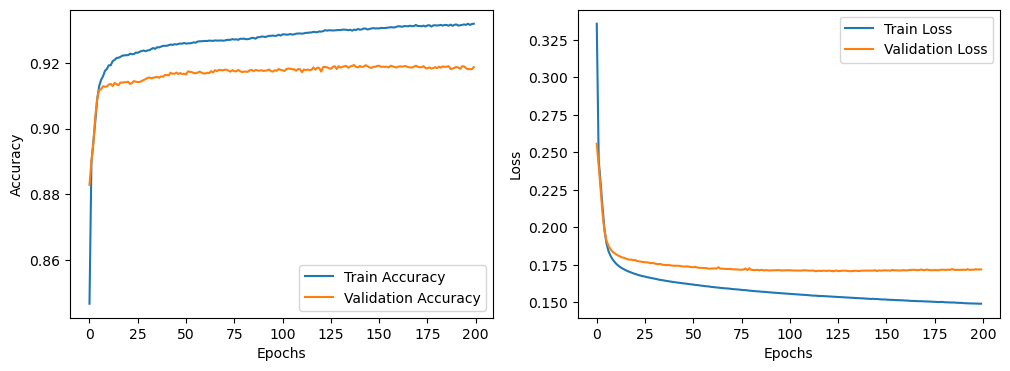

2179/2179 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9316 - loss: 0.1493
Media Accuracy Test: 0.9247


In [28]:
seeds = [0,1234534,2658742,3123089,415848,5741022,61354863,723154,8110000,9785412]
test_accs = []


for seed in seeds:

    #Settando il seed
    tf_random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

    #RIGA PER IL TAGLIO DEI DATI
    db_df_temp = db_df.copy()
    db_df_temp = smote(db_df_temp)
    db_df_temp = df_cut(db_df_temp)
    
    # Split features and labels
    x_train,y_train,x_test,y_test = shuffle_split(db_df_temp,seed)
    #Data scaling
    skrs = RobustScaler()
    X_train_RS = skrs.fit_transform(x_train)
    X_test_RS = skrs.fit_transform(x_test)
    #print(X_train_RS)


    print(np.shape(db_df_temp)[0],np.shape(db_df_temp)[1])
    
    #Modello --> 6 Layer - Relu - Sigmoid
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape = (np.shape(db_df_temp)[1]-1,)))
#   model.add(Dense(32, activation='relu', input_shape = (np.shape(db_df_temp)[1]-1,)))
#   model.add(Dense(64, activation = 'relu'))
#   model.add(Dropout(0.4))
    model.add(Dense(32, activation = 'relu'))
#    model.add(Dense(16, activation = 'relu'))
#    model.add(Dense(1, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model - print dell'addestramento
    history = model.fit(X_train_RS, y_train, epochs=200, batch_size=256, validation_split = 0.2)
    
    # Plot training history - Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # Plot training history - Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
    
    # Evaluate model on test set
    test_loss, test_accuracy = model.evaluate(X_test_RS, y_test)
    #print(f"Test Loss: {test_loss:4f}, Test Accuracy: {test_accuracy:4f}")
    
    #collezione delle accuracy sui set di test per ciascun seed
    test_accs.append(test_accuracy)

#media delle accuracy sui set di test
avg_test_acc = np.mean(test_accs)
print(f'Media Accuracy Test: {avg_test_acc:.4f}')



In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
test_accs = []


for seed in seeds:

    #Settando il seed
    tf_random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

    #RIGA PER IL TAGLIO DEI DATI
    db_df_temp = df_cut(db_df)
    
    # Split features and labels
    x_train,y_train,x_test,y_test = shuffle_split(db_df_temp,seed)
    #Data scaling
    skrs = RobustScaler()
    X_train_RS = skrs.fit_transform(x_train)
    X_test_RS = skrs.fit_transform(x_test)
    #print(X_train_RS)


    # Modello di regressione logistica
    logistic_model = LogisticRegression()
    
    # Addestramento del modello
    logistic_model.fit(X_train_RS, y_train)
    
    # Predizione sui dati di test
    y_pred = logistic_model.predict(X_test_RS)
    
    # Valutazione dell'accuratezza
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuratezza del modello di regressione logistica: {accuracy:.4f}")

    test_accs.append(accuracy)

#media delle accuracy sui set di test
avg_test_acc = np.mean(test_accs)
print(f'Media Accuracy Test: {avg_test_acc:.4f}')


Accuratezza del modello di regressione logistica: 0.8816
Accuratezza del modello di regressione logistica: 0.8808
Accuratezza del modello di regressione logistica: 0.8806
Accuratezza del modello di regressione logistica: 0.8828
Accuratezza del modello di regressione logistica: 0.8813
Accuratezza del modello di regressione logistica: 0.8816
Accuratezza del modello di regressione logistica: 0.8786
Accuratezza del modello di regressione logistica: 0.8845
Accuratezza del modello di regressione logistica: 0.8804
Accuratezza del modello di regressione logistica: 0.8810
Media Accuracy Test: 0.8813
